# 机器学习 神经网络-4

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio

In [4]:
data = sio.loadmat('ex4data1.mat')

In [5]:
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [6]:
x = data['X']
y = data['y']
x.shape, y.shape

((5000, 400), (5000, 1))

In [12]:
import matplotlib

In [15]:
def displayData(x):
    size = int(np.sqrt(x.shape[1]))
    sample_num  = np.random.choice(np.arange(5000),100)
    sample = x[sample_num,:]
    
    # 画图
    fig,ax = plt.subplots(nrows=10,ncols=10,sharex=True, sharey = True, figsize = (8,8))
    for i in range(10):
        for j in range(10):
            ax[i,j].matshow(sample[i*10+j].reshape((size,size)), cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()
                

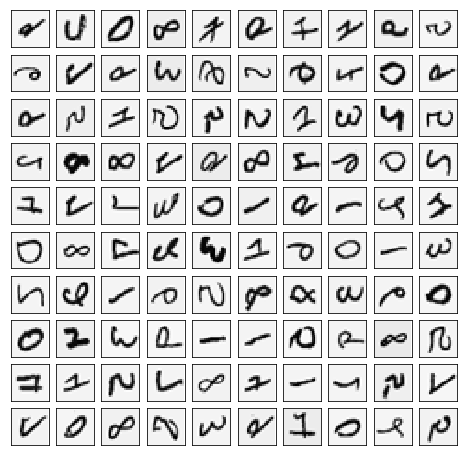

In [16]:
displayData(x)

## 1.重新编码y标签

In [17]:
y.shape

(5000, 1)

### 第一种方法 自己编写函数

In [18]:
def expand_y(y):
    num = y.shape[0]
    y_new = y.copy()
    y_new[y_new==10]=0
    tem1 = (y_new==0).astype(int)
    for i in range(1,10):
        tem = (y_new == i).astype(int)
        tem1 = np.concatenate((tem1,tem),axis= 1)
    tem1 = tem1.T
    return tem1

In [22]:
y_code = expand_y(y)
y[:5]

array([[10],
       [10],
       [10],
       [10],
       [10]], dtype=uint8)

###  第二种方法利用sklearn函数

In [23]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [24]:
y_onehot

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

## 读取权重

In [39]:
data_2 = sio.loadmat('ex4weights.mat')
theta1 = data_2['Theta1']
theta2 = data_2['Theta2']
theta1.shape,theta2.shape

((25, 401), (10, 26))

In [35]:
x.shape

(5000, 400)

In [37]:
x_1 = np.concatenate((np.ones((x.shape[0],1)), x),axis =1)
x_1.shape

(5000, 401)

In [29]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [51]:
def feedPropagation(theta1,theta2,x,y):
    a1 = x
    z2 = x@theta1.T
    a2 = sigmoid(z2)
    a2 = np.concatenate((np.ones((x.shape[0],1)),a2),axis = 1)
    
    z3 = a2@theta2.T
    h = sigmoid(z3)
    
    return a1,z2,a2,z3,h
    
    

In [44]:
h = feedPropagation(theta1,theta2, x_1,y_onehot)
h.shape

(5000, 10)

In [45]:
def cost(theta1,theta2,x,y):
    
    
    h = feedPropagation(theta1,theta2,x,y)
    cost_matrix = np.log(h)*y +np.log(1-h)*(1-y)
    return -np.sum(cost_matrix)/x.shape[0]

In [46]:
cost(theta1,theta2,x_1,y_onehot)

0.28762916516131892

In [47]:
def regularized_cost(theta1,theta2,x,y, l =1):
    sum_theta_1= np.sum(np.power(theta1[:,1:],2))
    sum_theta_2= np.sum(np.power(theta2[:,1:],2))
    
    return cost(theta1,theta2,x,y)+l/x.shape[0]/2*(sum_theta_1+sum_theta_2)

In [48]:
regularized_cost(theta1,theta2,x_1,y_onehot)

0.38376985909092365

In [49]:
def sigmoid_gradiend(z):
    return sigmoid(z)*(1-sigmoid(z))

In [50]:
sigmoid_gradiend(0)

0.25

In [67]:
def gradient(theta1,theta2,x,y):
    m = x.shape[0]
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    a1,z2,a2,z3,h = feedPropagation(theta1,theta2,x,y)
    for i in range(m):
        a1i = a1[i, :]  # (1, 401)
        z2i = z2[i, :]  # (1, 25)
        a2i = a2[i, :]  # (1, 26)

        hi = h[i, :]    # (1, 10)
        yi = y[i, :]    # (1, 10)

        d3i = hi - yi  # (1, 10)
        
        z2i = np.insert(z2i, 0, np.ones(1))
        #把z2i变成（1，26）
        d2i = np.multiply(theta2.T @ d3i, sigmoid_gradiend(z2i))  # (1, 26)

        # careful with np vector transpose
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)  # (1, 10).T @ (1, 26) -> (10, 26)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)  # (1, 25).T @ (1, 401) -> (25, 401)

    delta1 = delta1 / m
    delta2 = delta2 / m
    return delta1,delta2

In [68]:
d1,d2 = gradient(theta1,theta2,x_1,y_onehot)
d1.shape,d2.shape

((25, 401), (10, 26))